In [228]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [229]:
sns.set_palette('bright')
sns.set_context("talk")
sns.set_style("darkgrid")

In [230]:
df_MAIN = pd.read_csv('/home/crazyjeannot/Documents/doctorat/data/data_chapitres/TRAINING_data/MAIN_DF.csv')
df_MAIN.set_index("Unnamed: 0", inplace = True)
df_MAIN = df_MAIN.replace(np.nan, 0)

In [280]:
def normalize_vectors_as_probabilities(df):
    # Get the columns containing the vectors (excluding the 'date' column)
    vector_columns = [col for col in df.columns if col != 'date']

    # Create the MinMaxScaler object
    scaler = MinMaxScaler()

    # Normalize each vector to represent a probability distribution
    for col in vector_columns:
        vector = df[col].values.reshape(-1, 1)
        normalized_vector = scaler.fit_transform(vector).flatten()
        df[col] = normalized_vector

    return df

In [281]:
df_MAIN_normalized = normalize_vectors_as_probabilities(df_MAIN)

In [233]:
def normalize_vectors_as_probabilities(df):
    # Get the columns containing the vectors (excluding the 'date' column)
    vector_columns = [col for col in df.columns if col != 'date']

    # Normalize each vector to represent a probability distribution
    for col in vector_columns:
        vector = df[col].values
        abs_vector = np.abs(vector)
        vector_sum = np.sum(abs_vector)
        if vector_sum > 0:
            normalized_vector = abs_vector / vector_sum  # Normalize to sum up to 1
            df[col] = normalized_vector

    return df

In [234]:
df_MAIN_normalized = normalize_vectors_as_probabilities(df_MAIN)

In [235]:
## Two normalizations, first one gets better results ?

In [282]:
def get_df_with_dates(df):
    df_res = df.copy()
    list_date = []
    for elem in df_res.index:
        list_date.append(int(elem.split('_')[0]))
    df_res['date'] = list_date

    return df_res

In [283]:
df_MAIN_dated = get_df_with_dates(df_MAIN_normalized)

In [284]:
def calculate_entropy(df, window, first_date, last_date):
    NOVELTY, INFLUENCE, novels, dates = [], [], [], []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        current_date = row['date']
        if current_date-window < first_date or current_date+window > last_date:
            continue
        start_date = max(first_date, current_date - window)
        end_date = min(last_date, current_date + window)

        # Filter texts within the specified window
        novelty_texts = df[(df['date'] >= first_date) & (df['date'] <= start_date)].drop('date', axis=1)
        influence_texts = df[(df['date'] >= end_date) & (df['date'] <= last_date)].drop('date', axis=1)

        # Compute the entropy of the text
        text_novelty = entropy(row.drop('date').values, np.mean(novelty_texts.values, axis=0))
        text_influence = entropy(row.drop('date').values, np.mean(influence_texts.values, axis=0))

        NOVELTY.append(text_novelty)
        INFLUENCE.append(text_influence)
        novels.append(index)
        dates.append(current_date)
    return NOVELTY, INFLUENCE, novels, dates


In [285]:
NOVELTY, INFLUENCE, novels, dates = calculate_entropy(df_MAIN_dated, 35, 1811, 2020)

  0%|          | 0/2940 [00:00<?, ?it/s]

In [286]:
def net_entropy(indexes, dates, entropies):
    net_index, net_dates, net_entropy = [], [], []
    i=0
    for index, date, entropy in zip(indexes, dates, entropies):
        if ~np.isinf(entropy):
            net_index.append(str(index))
            net_dates.append(int(date))
            net_entropy.append(float(entropy))
        else:
            i+=1
    print("faulty entropy values : ", i)
    return net_index, net_dates, net_entropy

In [287]:
net_novels_nov, net_dates_nov, net_NOVELTY = net_entropy(novels, dates, NOVELTY)

faulty entropy values :  323


In [288]:
data_nov = pd.DataFrame({'Index': net_novels_nov, 'Date': net_dates_nov, 'Mean_NOVELTY': net_NOVELTY})

In [289]:
net_novels_inf, net_dates_inf, net_INFLUENCE = net_entropy(novels, dates, INFLUENCE)

faulty entropy values :  46


In [290]:
data_inf = pd.DataFrame({'Index': net_novels_inf, 'Date': net_dates_inf, 'Mean_INFLUENCE': net_INFLUENCE})

### GET BEST NOVELS

In [291]:
best_inf = data_inf[data_inf['Mean_INFLUENCE']>0.2]

In [292]:
best_inf

,Index,Date,Mean_INFLUENCE
2,1846_Balzac-Honore-de_Gaudissart_II,1846,0.237883
114,1853_Sand-George_La-fauvette-du-docteur,1853,0.369342
282,1862_Hugo-Victor_Les-Miserables,1862,0.206377
313,1864_Dumas-Alexandre_La-San-Felice,1864,0.224474
352,1866_Gouraud-Julie_Mémoires-d'un-caniche,1866,0.376165
468,1872_Daudet-Alphonse_Le-Bon-Dieu-de-Chemille-q...,1872,0.394407
469,1872_Daudet-Alphonse_Le-Pere-Achille,1872,0.361979
489,1873_Daudet-Alphonse_Le-Cabecilla,1873,0.351578
490,1873_Daudet-Alphonse_Salvette-et-Bernadou,1873,0.321994
491,1873_Daudet-Alphonse_Wood-stown,1873,0.404142


In [293]:
best_nov = data_nov[data_nov['Mean_NOVELTY']>0.22]

In [294]:
best_nov

,Index,Date,Mean_NOVELTY
3,1853_Sand-George_La-fauvette-du-docteur,1853,0.396649
72,1862_Hugo-Victor_Les-Miserables,1862,0.231989
102,1864_Dumas-Alexandre_La-San-Felice,1864,0.226265
140,1866_Gouraud-Julie_Mémoires-d'un-caniche,1866,0.376587
229,1872_Daudet-Alphonse_Le-Bon-Dieu-de-Chemille-q...,1872,0.413107
230,1872_Daudet-Alphonse_Le-Pere-Achille,1872,0.378698
249,1873_Daudet-Alphonse_Le-Cabecilla,1873,0.355182
250,1873_Daudet-Alphonse_Salvette-et-Bernadou,1873,0.342597
251,1873_Daudet-Alphonse_Wood-stown,1873,0.421478
298,1875_Verne-Jules_L-Ile-Mysterieuse,1875,0.241202


### BEST AUTHORS ?

### PLOT INFLUENCE / NOVELTY

In [295]:
merged_df = pd.merge(data_nov, data_inf, on='Index', how='inner')

In [296]:
merged_df

,Index,Date_x,Mean_NOVELTY,Date_y,Mean_INFLUENCE
0,1851_Souvestre-Emile_Les-derniers-paysans_Tome-2,1851,0.115046,1851,0.089796
1,1853_Dumas-Alexandre_Les-drames-de-la-mer,1853,0.148513,1853,0.130235
2,1853_Poulain-Jules_Le-Dartmoor-ou-les-Deux-soe...,1853,0.078955,1853,0.075911
3,1853_Sand-George_La-fauvette-du-docteur,1853,0.396649,1853,0.369342
4,1854_Bassanville-Anais-de_Les-Primeurs-de-la-v...,1854,0.088541,1854,0.080066
...,...,...,...,...,...
1873,1981_Bouvier-Nicolas_Le-poisson-scorpion,1981,0.076944,1981,0.070155
1874,1981_Gary-Romain_Vie-et-mort-d-Emile-Ajar,1981,0.208773,1981,0.192492
1875,1981_Robbe-Grillet-Alain_Djinn,1981,0.077618,1981,0.070329
1876,1981_Villard-Marc_Corvette-de-nuit,1981,0.101932,1981,0.087306


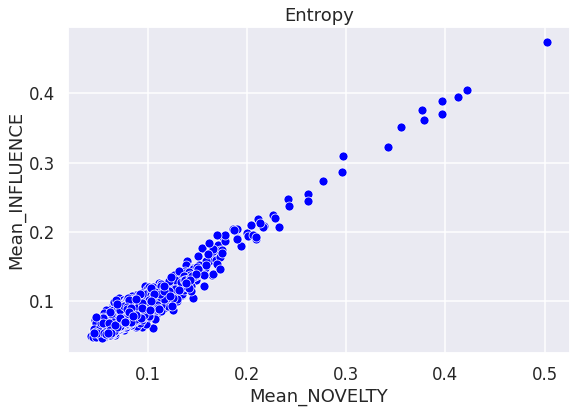

In [297]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.set_title('Entropy')

ax = sns.scatterplot(data=merged_df, x="Mean_NOVELTY", y="Mean_INFLUENCE", color='blue', ax=ax)

ax.set_xlabel('Mean_NOVELTY')
ax.set_ylabel('Mean_INFLUENCE')

plt.show()

In [298]:
df_corpus = pd.read_csv(r'/home/crazyjeannot/Documents/master/M2/master_thesis/meta_data/corpus.csv')
df_corpus.set_index(['doc_name'], inplace=True)

In [299]:
def get_df_with_subgenre(df, df_corpus):
    df_res = df.copy()
    list_subgenre = []
    for elem in list(df_res.index):
        if elem in list(df_corpus.index):
            list_subgenre.append(df_corpus.loc[elem].genre)
        else:
            list_subgenre.append('')
    df_res['subgenre'] = list_subgenre

    return df_res

In [300]:
df_MAIN_genred = get_df_with_subgenre(merged_df.set_index('Index'), df_corpus)

In [301]:
genres_ok = ["roman d'aventures",
'roman historique',
'policier',
'littérature jeunesse',
'mémoires et autobiographie',
'roman sentimental']

In [302]:
df_MAIN_genred_ok = df_MAIN_genred[df_MAIN_genred.subgenre.isin(genres_ok)]

In [303]:
df_MAIN_genred_ok

,Date_x,Mean_NOVELTY,Date_y,Mean_INFLUENCE,subgenre
Index,,,,,
1853_Dumas-Alexandre_Les-drames-de-la-mer,1853,0.148513,1853,0.130235,roman d'aventures
1854_Bassanville-Anais-de_Les-Primeurs-de-la-vie-ou-Bonheurs-joies-et-douleurs-de-la-jeunesse,1854,0.088541,1854,0.080066,littérature jeunesse
1854_Dumas-Alexandre_Le-capitaine-Richard,1854,0.094801,1854,0.067686,roman d'aventures
1855_Dumas-Alexandre_Le-page-du-duc-de-Savoie_II,1855,0.106657,1855,0.087185,roman d'aventures
1855_Dumas-Alexandre_Le-page-du-duc-de-Savoie_III,1855,0.077469,1855,0.067805,roman d'aventures
...,...,...,...,...,...
1980_Siniac-Pierre_L-unijambiste-de-la-cote-284,1980,0.060376,1980,0.053443,policier
1980_Siniac-Pierre_Reflets-changeants-sur-mare-de-sang,1980,0.067160,1980,0.065622,policier
1980_Tournier-Michel_Gaspard-Melchior-Et-Balthazar,1980,0.072265,1980,0.075480,roman historique


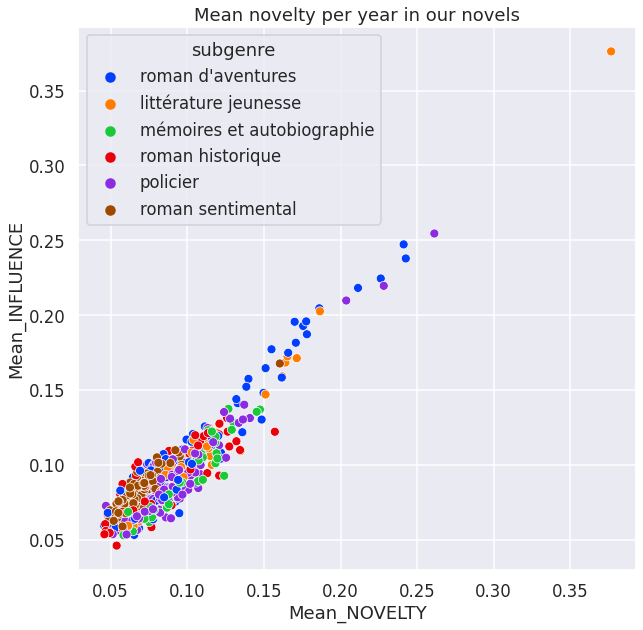

In [304]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.set_title('Mean novelty per year in our novels')

ax = sns.scatterplot(data=df_MAIN_genred_ok, x="Mean_NOVELTY", y="Mean_INFLUENCE", color='blue', ax=ax, hue='subgenre')

ax.set_xlabel('Mean_NOVELTY')
ax.set_ylabel('Mean_INFLUENCE')

plt.show()

In [305]:
df_corpus_canon = pd.read_csv(r'/home/crazyjeannot/Documents/master/M2/master_thesis/meta_data/df_canon_spec_last.csv')
df_corpus_canon.set_index(['doc_name'], inplace=True)

In [306]:
def get_df_with_canon(df, df_corpus):
    df_res = df.copy()
    list_subgenre = []
    for elem in list(df_res.index):
        if elem in list(df_corpus.index):
            list_subgenre.append(df_corpus.loc[elem].canon_roman)
        else:
            list_subgenre.append('')
    df_res['canon'] = list_subgenre

    return df_res

In [307]:
df_MAIN_canon = get_df_with_canon(merged_df.set_index('Index'), df_corpus_canon)

In [308]:
df_MAIN_canon

,Date_x,Mean_NOVELTY,Date_y,Mean_INFLUENCE,canon
Index,,,,,
1851_Souvestre-Emile_Les-derniers-paysans_Tome-2,1851,0.115046,1851,0.089796,non_canon
1853_Dumas-Alexandre_Les-drames-de-la-mer,1853,0.148513,1853,0.130235,non_canon
1853_Poulain-Jules_Le-Dartmoor-ou-les-Deux-soeurs-scenes-de-la-vie-anglaise,1853,0.078955,1853,0.075911,non_canon
1853_Sand-George_La-fauvette-du-docteur,1853,0.396649,1853,0.369342,non_canon
1854_Bassanville-Anais-de_Les-Primeurs-de-la-vie-ou-Bonheurs-joies-et-douleurs-de-la-jeunesse,1854,0.088541,1854,0.080066,non_canon
...,...,...,...,...,...
1981_Bouvier-Nicolas_Le-poisson-scorpion,1981,0.076944,1981,0.070155,non_canon
1981_Gary-Romain_Vie-et-mort-d-Emile-Ajar,1981,0.208773,1981,0.192492,non_canon
1981_Robbe-Grillet-Alain_Djinn,1981,0.077618,1981,0.070329,non_canon


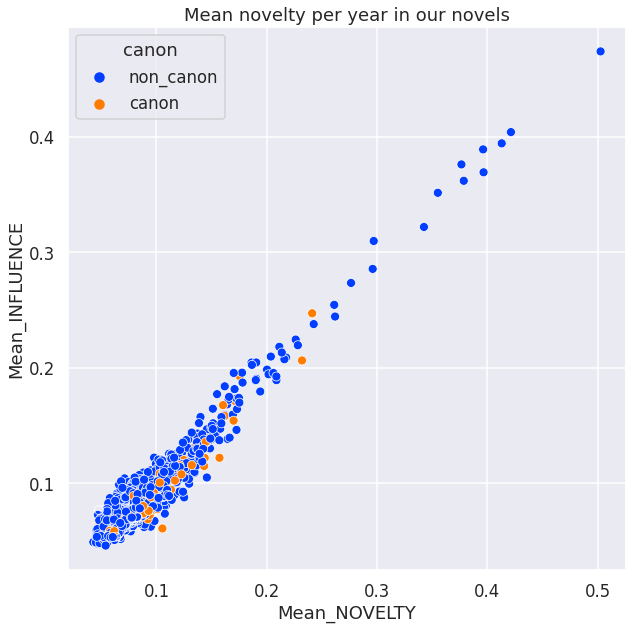

In [309]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.set_title('Mean novelty per year in our novels')

ax = sns.scatterplot(data=df_MAIN_canon, x="Mean_NOVELTY", y="Mean_INFLUENCE", color='blue', ax=ax, hue='canon', hue_order=['non_canon', 'canon'])

ax.set_xlabel('Mean_NOVELTY')
ax.set_ylabel('Mean_INFLUENCE')

plt.show()

In [310]:
df_MAIN_canon_temp = df_MAIN_canon[(df_MAIN_canon["Mean_NOVELTY"]<0.25) & (df_MAIN_canon["Mean_INFLUENCE"]<0.25)]

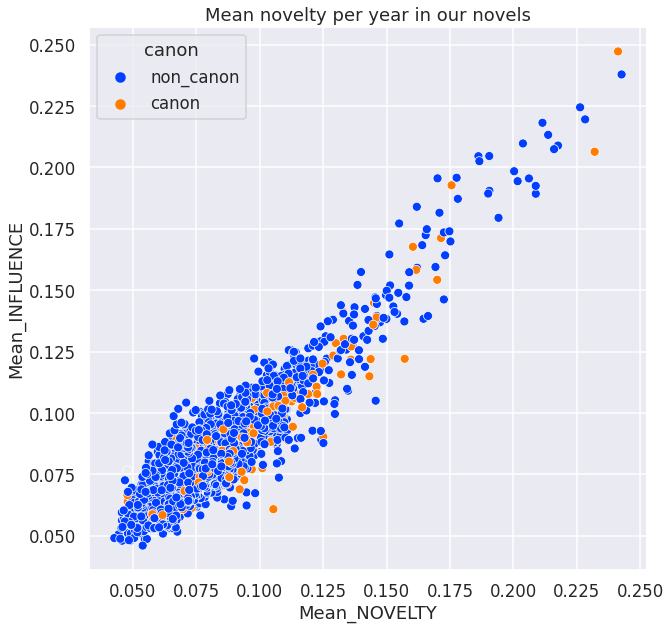

In [311]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.set_title('Mean novelty per year in our novels')

ax = sns.scatterplot(data=df_MAIN_canon_temp, x="Mean_NOVELTY", y="Mean_INFLUENCE", color='blue', ax=ax, hue='canon', hue_order=['non_canon', 'canon'])

ax.set_xlabel('Mean_NOVELTY')
ax.set_ylabel('Mean_INFLUENCE')

plt.show()

In [312]:
df_MAIN_canon_noncanon = df_MAIN_canon_temp[df_MAIN_canon_temp["canon"]=='non_canon']

In [313]:
df_MAIN_canon_canon = df_MAIN_canon_temp[df_MAIN_canon_temp["canon"]=='canon']

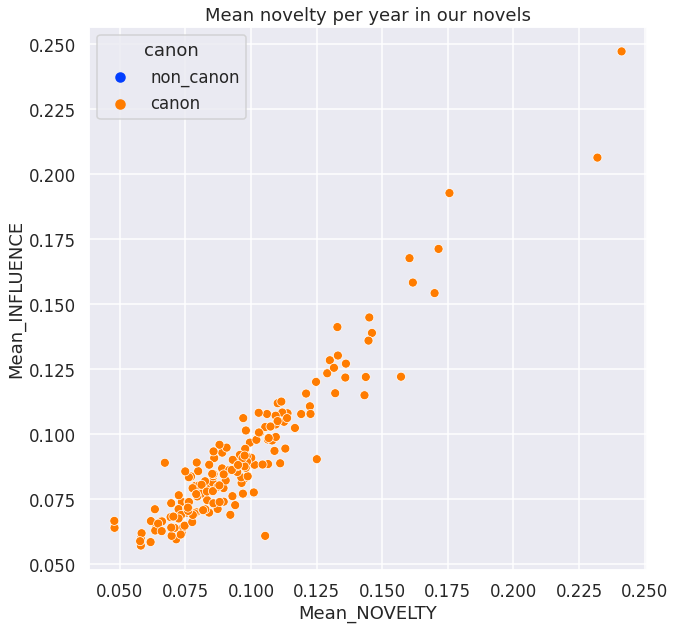

In [314]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.set_title('Mean novelty per year in our novels')

ax = sns.scatterplot(data=df_MAIN_canon_canon, x="Mean_NOVELTY", y="Mean_INFLUENCE", color='blue', ax=ax, hue='canon', hue_order=['non_canon', 'canon'])

ax.set_xlabel('Mean_NOVELTY')
ax.set_ylabel('Mean_INFLUENCE')

plt.show()

In [315]:
tmp = df_MAIN_canon_canon[(df_MAIN_canon_canon["Mean_NOVELTY"]>0.15) & (df_MAIN_canon_canon["Mean_INFLUENCE"]>0.15)]

In [316]:
tmp

,Date_x,Mean_NOVELTY,Date_y,Mean_INFLUENCE,canon
Index,,,,,
1862_Hugo-Victor_Les-Miserables,1862,0.231989,1862,0.206377,canon
1863_Farrenc-Cesarie_La-jalousie,1863,0.171456,1863,0.171248,canon
1870_Verne-Jules_Vingt-mille-lieues-sous-les-mers,1870,0.161659,1870,0.158303,canon
1875_Verne-Jules_L-Ile-Mysterieuse,1875,0.241202,1875,0.247232,canon
1885_Verne-Jules_Mathias-Sandorf,1885,0.175608,1885,0.192744,canon
1935_Delly_Contes,1935,0.160383,1935,0.167689,canon
1939_Sarraute-Nathalie_Tropismes,1939,0.169943,1939,0.154247,canon


In [317]:
df_concat = pd.concat([df_MAIN_canon_noncanon, df_MAIN_canon_canon])

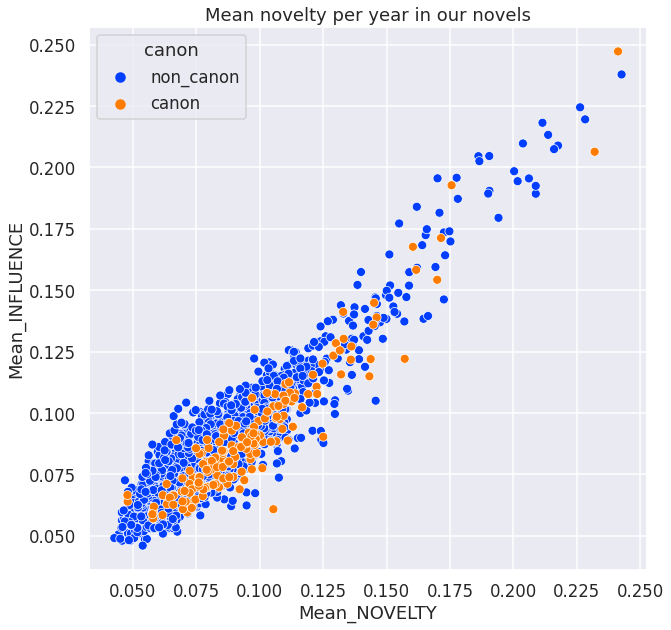

In [318]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.set_title('Mean novelty per year in our novels')

ax = sns.scatterplot(data=df_concat, x="Mean_NOVELTY", y="Mean_INFLUENCE", color='blue', ax=ax, hue='canon', hue_order=['non_canon', 'canon'])

ax.set_xlabel('Mean_NOVELTY')
ax.set_ylabel('Mean_INFLUENCE')

plt.show()

## PLOT PER YEAR

In [319]:
def get_df_to_plot(dates, entropy_values):
    # Calculate the mean entropy for each date and handle infinite values
    unique_dates = np.unique(dates)
    mean_entropy = []

    for date in unique_dates:
        indices_for_date = np.where(dates == date)[0]
        if max(indices_for_date)<=len(entropy_values):
            entropy_for_date = np.array(entropy_values)[indices_for_date]
        
        if len(entropy_for_date) > 0:
            mean_entropy_for_date = np.mean(entropy_for_date)
        else:
            mean_entropy_for_date = np.nan
        
        mean_entropy.append(mean_entropy_for_date)
        
    # Create a DataFrame with dates and mean entropy values
    data = pd.DataFrame({'Date': unique_dates, 'Mean Entropy': mean_entropy})
    return data

In [320]:
df_novelty = get_df_to_plot(net_dates_nov, net_NOVELTY)

In [321]:
df_influence = get_df_to_plot(net_dates_nov, net_INFLUENCE)

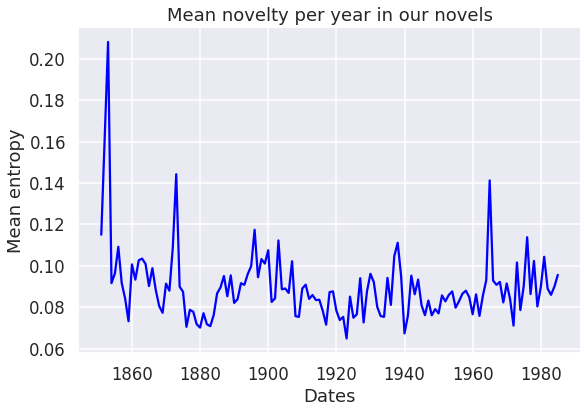

In [322]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.set_title('Mean novelty per year in our novels')

ax = sns.lineplot(data=df_novelty, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='blue', 
                 ax=ax)

ax.set_xlabel('Dates')
ax.set_ylabel('Mean entropy')

plt.show()

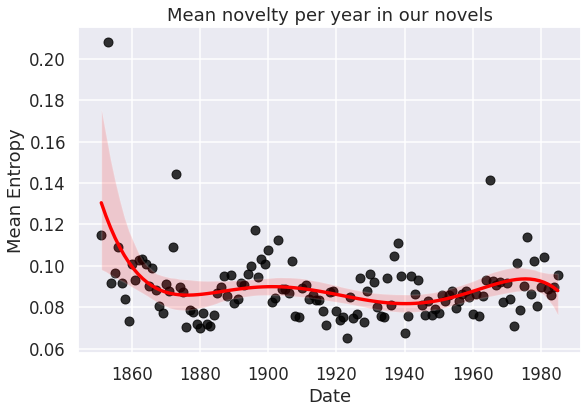

In [323]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.set_title('Mean novelty per year in our novels')

ax = sns.regplot(data=df_novelty, 
                 x='Date', 
                 y='Mean Entropy', 
                 scatter_kws={"color": "black"}, 
                 line_kws={"color": "red"},              
                 order=5, 
                 scatter=True, 
                 ax=ax)

plt.show()

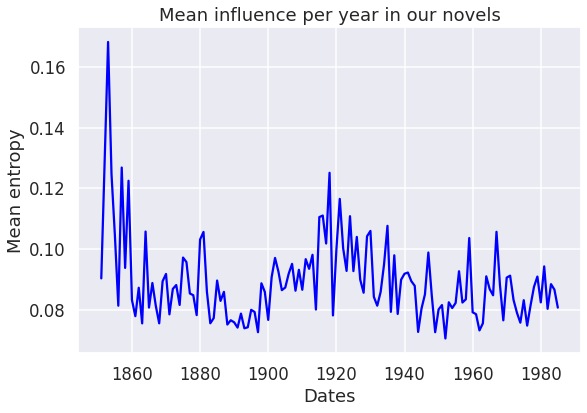

In [324]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.set_title('Mean influence per year in our novels')

ax = sns.lineplot(data=df_influence, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='blue', 
                 ax=ax)

ax.set_xlabel('Dates')
ax.set_ylabel('Mean entropy')

plt.show()

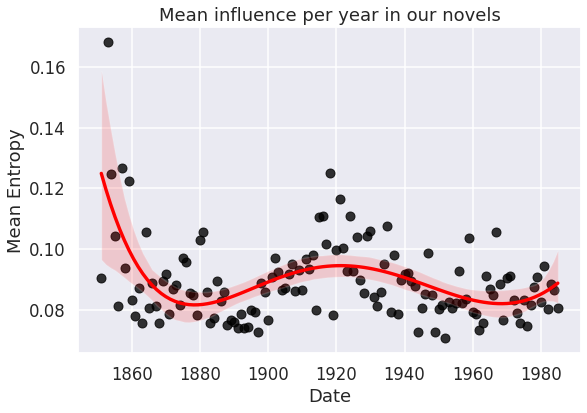

In [325]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.set_title('Mean influence per year in our novels')

ax = sns.regplot(data=df_influence, 
                 x='Date', 
                 y='Mean Entropy', 
                 scatter_kws={"color": "black"}, 
                 line_kws={"color": "red"},              
                 order=5, 
                 scatter=True, 
                 ax=ax)

plt.show()